In [9]:
import      numpy               as      np
import      matplotlib.pyplot   as      plt
from        lib_Experimentum    import  *
from        Alessandria         import  *


#path dove stanno i dati del fit
now_path         =   '../BRILLOUIN/TDP43/ARS_13_02/analysis_new_nodelta/'


### recupero info su dimensionalità
spectra_path =   '../BRILLOUIN/TDP43/ARS_13_02/'
spectra_filename    =   'ARS_13_02'
n_rows    =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3'))
n_cols  =   len(Import_from_Matlab(spectra_filename, spectra_path, var_name = 'y3')[0])
###
matrix, rows, cols = Initialize_Matrix(0,0,n_rows,n_cols)

Ho inizializzato una matrice 89x85, per un totale di 7565 spettri


In [10]:

#1) Recupero info su posizioni + info su chi è bono e chi no e su VIPA (questo solo per matrix[0][0])

with open(now_path+'xy.txt', 'r') as fin:
    lines = fin.readlines()[1:]

excluded = ()

with open(now_path+'markov_fit.txt', 'r') as fin:
    fit     =   eval(fin.read())
_,_,_, boni = Unpack_Fit(fit)

with open(now_path+'xy_VIPA.txt', 'r') as fin:
    VIPAs = fin.readlines()[1:]

x_VIPA = np.array(VIPAs[0][1:-2].split(), dtype=float)
y_VIPA = np.array(VIPAs[1][1:-2].split(), dtype=float)


for (ii,jj) in boni:
    matrix[ii][jj].Recover_VIPA(x_VIPA, y_VIPA)


count = 0
for (ii,jj) in serpentine_range(n_rows, n_cols, 'right'):
        matrix[ii][jj].Recover_Spectrum(np.array(lines[count][1:-2].split(), dtype=float), np.array(lines[count+1][1:-2].split(), dtype=float))
        
        if (ii,jj) not in boni:
            excluded = excluded +((ii,jj),)

        count = count + 2

print('Ok ho recuperato le informazioni sulle posizioni')

Ok ho recuperato le informazioni sulle posizioni


In [11]:
#2) Acquisico i dati prodotti dal fit markoviano


##################### MARKOVIANO

with open(now_path+'y_markov_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_markov.txt', 'r') as fin:
    costi = fin.readlines()

with open(now_path+'markov_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni parametri fit ({})".format(len(boni), len(lines)))
if (len(boni) != len(costi)):
    raise ValueError("Incompatibilità tra lunghezza boni ({}) e informazioni costo fit ({})".format(len(boni), len(costi)))
if (len(boni) != len(y_fits)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e y fit ({})".format(len(boni), len(y_fits)))


for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,   boni) :
    matrix[ii][jj].Recover_Markov_Fit_Params(line)
    matrix[ii][jj].Recover_y_markov_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_markov(float(cost))

print('Ok ho recuperato le informazioni del Fit Markoviano')




Ok ho recuperato le informazioni del Fit Markoviano


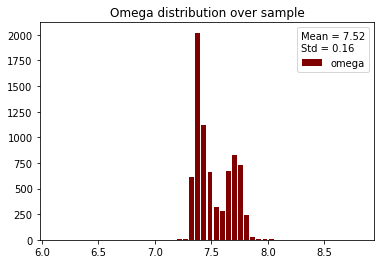

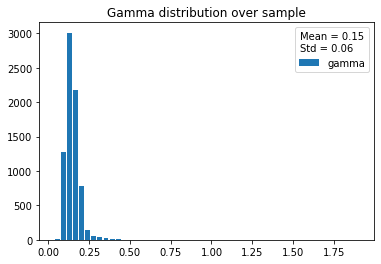

In [12]:
#HISTOGRAMs - MARKOV
markov_Omegas = np.array([matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
markov_Gammas =  np.array([matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])


plt.figure()
plt.title('Omega distribution over sample')
_ = plt.hist(markov_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Omegas), np.std(markov_Omegas)))
plt.savefig(now_path+'Omega_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample')
_ = plt.hist(markov_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(markov_Gammas), np.std(markov_Gammas)))
plt.savefig(now_path+'Gamma_markov_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


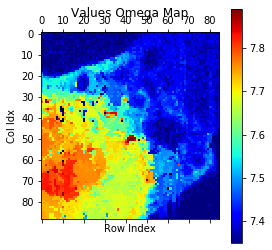

Completata Parameter_Map per Omega
Ho trovato 15 elementi saturati


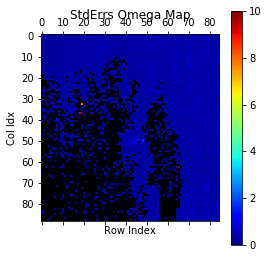

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


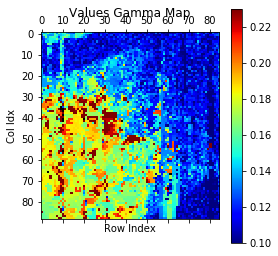

Completata Parameter_Map per Gamma
Ho trovato 15 elementi saturati


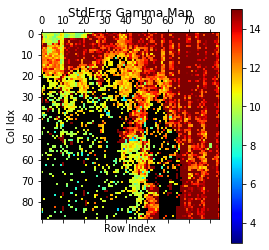

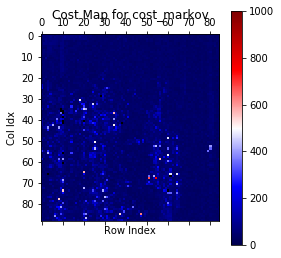

In [16]:
#MAPPE
omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 7.89, fig = 'omega_markov_map', path=now_path)
Delta_omega_markov_map, _ = Get_Parameter_Map('markov', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,10, fig = 'Delta_omega_markov_map', path=now_path, Deltas = True)
gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.23, fig = 'Gamma_markov_map', path=now_path)
Delta_gamma_markov_map, _ = Get_Parameter_Map('markov', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 3, 15, fig = 'Delta_Gamma_markov_map', path=now_path, Deltas = True)
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)

In [13]:
#Parametri di Interesse per analisi
markov_too_bad = ()
markov_too_good  = ()
markov_omega_too_high =  ()
markov_gamma_too_bad = ()

markov_omega_max = np.mean(markov_Omegas)+5*np.std(markov_Omegas)
markov_gamma_max = np.mean(markov_Gammas)+5*np.std(markov_Gammas)
cost_max = 1000
cost_min = 50


markov_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'markov')
markov_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'markov')
markov_omega_too_high = Whose_Param_Too_High('Omega', markov_omega_max, 'markov', matrix, boni)
markov_gamma_too_high = Whose_Param_Too_High('Gamma', markov_gamma_max, 'markov', matrix, boni)


#aggiunte 
markov_too_offset = ()
percentage_gamma = 15
max_offset = 30
markov_almost_height = ()

for (ii,jj) in boni:
    if matrix[ii][jj].Markov_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Markov_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        markov_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Markov_Fit_Params['offset'].values[0] > max_offset:
        markov_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        markov_almost_height += ((ii,jj),)


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(markov_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(markov_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(markov_omega_too_high), markov_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(markov_gamma_too_high), markov_gamma_max))

print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(markov_too_offset), max_offset))





I found 0 bad elements out of 7550

I found 5061 good elements out of 7550

(37, 18) ha Omega= 8.81
(33, 20) ha Gamma= 0.69
(33, 19) ha Gamma= 1.51
(34, 20) ha Gamma= 0.69
(34, 24) ha Gamma= 1.66
(38, 30) ha Gamma= 1.21
(39, 20) ha Gamma= 0.56
(40, 7) ha Gamma= 0.55
(41, 7) ha Gamma= 0.56
(42, 9) ha Gamma= 0.74
(42, 20) ha Gamma= 0.67
(42, 24) ha Gamma= 0.67
(50, 45) ha Gamma= 0.48
(50, 48) ha Gamma= 0.63
(51, 48) ha Gamma= 0.48
(51, 46) ha Gamma= 1.91
(51, 45) ha Gamma= 0.43
(55, 79) ha Gamma= 0.44
(73, 20) ha Gamma= 0.52




Ho trovato per i dati fit markov in ../BRILLOUIN/TDP43/ARS_13_02/analysis_new_nodelta/ :

0 elementi con chi quadro > 1000 
5061 elementi con chi quadro < 50 

1 elementi con Omega > Omega max 8.31
18 elementi con Gamma > Gamma max 0.43

1767 elementi con Gamma con errore percentuale > 15 

0 elementi con offset > 30 



In [30]:
no_delta = []
for (ii, jj) in boni:
    if not 'delta_position' in matrix[ii][jj].Markov_Fit_Params.keys():
        no_delta.append((ii,jj))
print(len(no_delta))


66


In [31]:
print(len(no_delta))
print(len(boni)-len(no_delta))
special = []
for (ii, jj) in boni:
    if ((ii,jj) not in no_delta) & ((ii,jj) not in markov_gamma_too_high):
        special.append((ii,jj))
print(len(special))

66
7484
7466


(12, 35)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.013136  7.552333  0.185041  2.698788e+03   9.585780  16.491011   
StdErrs   0.013258  0.023181  0.015366  6.032278e+09  16.235479  26.718668   
Initials  0.011647  7.467845  0.149558  3.372833e+03   9.490871  16.474536   

             shift    offset  
Values    0.193302  2.000000  
StdErrs   0.021274  0.574288  
Initials  0.232111  2.000000  


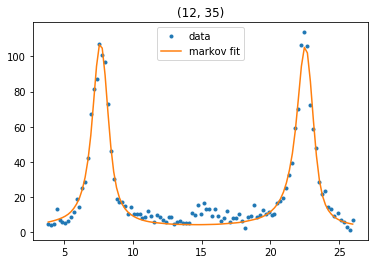

(15, 39)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.012887  7.490203  0.182307  3.238300e+03   9.489922  16.474520   
StdErrs   0.014501  0.024521  0.015880  7.484091e+09  18.480697  29.937652   
Initials  0.013136  7.552333  0.185041  2.698788e+03   9.585780  16.491011   

             shift    offset  
Values    0.204395  2.000000  
StdErrs   0.021961  0.557672  
Initials  0.193302  2.000000  


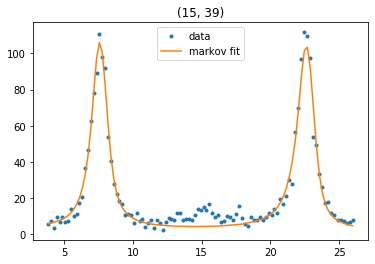

(19, 16)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.012001  7.547716  0.156774  2.271095e+03   9.958220  16.526863   
StdErrs   0.016557  0.021024  0.014312  3.714821e+09  21.659598  36.768517   
Initials  0.011013  7.430815  0.154945  2.838856e+03   9.859624  16.510352   

             shift    offset  
Values   -0.030558  2.000000  
StdErrs   0.020821  0.569821  
Initials  0.019779  0.863111  


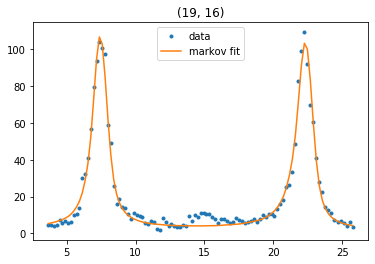

(20, 17)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.013478  7.521485  0.185932  2.384836e+03   9.774497  16.521690   
StdErrs   0.014450  0.023521  0.015602  5.176297e+09  16.769456  28.666788   
Initials  0.012243  7.513550  0.144492  1.990681e+03   9.677720  16.505184   

             shift    offset  
Values    0.176355  2.000000  
StdErrs   0.021324  0.563466  
Initials  0.198581  2.000000  


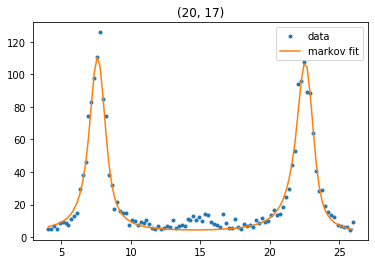

(21, 1)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.012387  7.485371  0.150433  2.825282e+02  11.024771  16.440643   
StdErrs   0.015694  0.020035  0.014062  5.652558e+08  14.666321  33.425123   
Initials  0.011864  7.506895  0.140640  3.531598e+02  11.136133  16.457100   

             shift    offset  
Values    0.155140  2.000000  
StdErrs   0.020020  0.548653  
Initials  0.140088  1.999631  


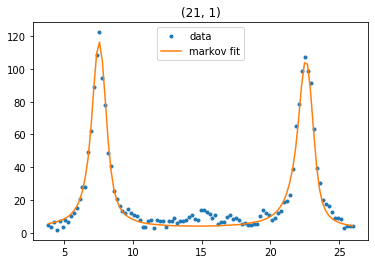

(24, 49)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.012585  7.392160  0.143982  1.261632e+03   9.038872  16.523742   
StdErrs   0.016574  0.019372  0.013289  2.428193e+09  23.215240  35.547770   
Initials  0.011369  7.362733  0.104964  1.051366e+03   9.130174  16.540283   

             shift    offset  
Values    0.346127  2.000000  
StdErrs   0.019631  0.650596  
Initials  0.338262  2.000000  


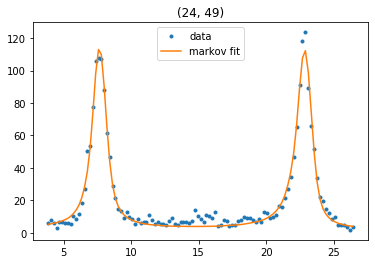

(28, 22)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.013171  7.507570  0.172211  2.892857e+03  10.210564  16.648224   
StdErrs   0.015174  0.023519  0.015021  5.091864e+09  16.704930  31.544388   
Initials  0.012468  7.520243  0.168824  2.410714e+03  10.109470  16.631593   

             shift    offset  
Values    0.155478  2.000000  
StdErrs   0.021181  0.571360  
Initials  0.102027  1.999999  


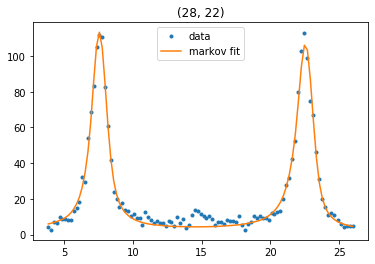

(29, 11)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.011992  7.575974  0.143040  1.761234e+03  10.247508  16.588790   
StdErrs   0.016709  0.020321  0.013656  3.037282e+09  19.470860  37.522889   
Initials  0.012146  7.570788  0.152590  2.201542e+03  10.351018  16.605395   

             shift    offset  
Values    0.228767  1.570964  
StdErrs   0.020185  0.564390  
Initials  0.212038  0.973317  


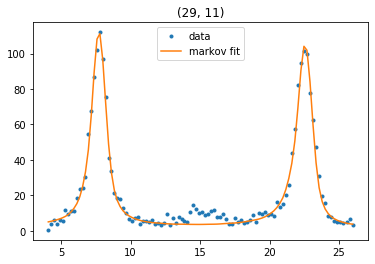

(30, 18)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.012113  7.683680  0.174528  2.668784e+03  10.374579  16.557435   
StdErrs   0.014042  0.022914  0.015464  5.622932e+09  16.606192  30.660672   
Initials  0.012720  7.597104  0.159473  3.335850e+03  10.479372  16.574009   

             shift    offset  
Values   -0.072442  1.334469  
StdErrs   0.021662  0.521088  
Initials  0.169186  1.938275  


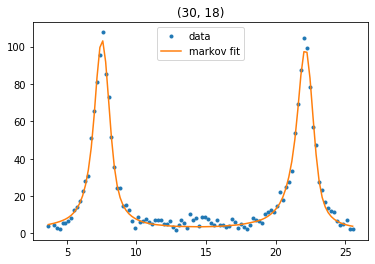

(30, 43)
                Co     Omega     Gamma             A         mu      sigma  \
Values    0.013059  7.448855  0.177432  8.679729e+02   9.308765  16.573313   
StdErrs   0.013514  0.022958  0.014975  1.641806e+09  17.928006  28.078200   
Initials  0.011464  7.448735  0.139458  1.083131e+03   9.402793  16.589903   

             shift    offset  
Values    0.197330  2.000000  
StdErrs   0.021262  0.565168  
Initials  0.180193  2.000000  


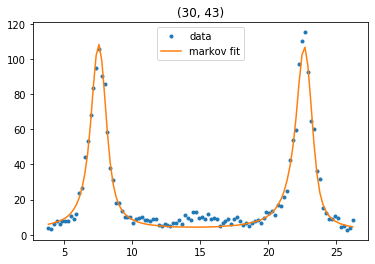

In [29]:
Plot_Elements_Spectrum(matrix, no_delta[:10], fit = 'markov')

(33, 20)
                Co     Omega     Gamma  delta_position    delta_width  \
Values    0.031145  7.308724  0.694005        0.428587  446048.634295   
StdErrs        NaN       NaN       NaN             NaN            NaN   
Initials  0.024321  7.401193  0.270787        1.999894  446047.360009   

          delta_amplitude           A         mu      sigma     shift  \
Values         434.823694  123.040553  10.146838  16.590176  0.126106   
StdErrs               NaN         NaN        NaN        NaN       NaN   
Initials       336.161988  126.540447  10.046445  16.573670  0.186863   

            offset  
Values   -1.936408  
StdErrs        NaN  
Initials  2.000000  


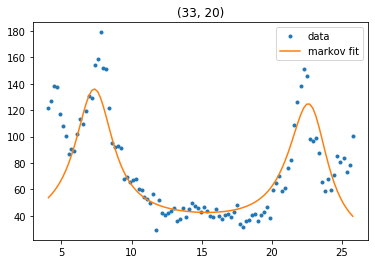

(33, 19)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.082102  6.337494  1.508729   -8.731542e-01  4.484539e+05   
StdErrs   0.034524  0.508594  0.178470    4.386333e+06  2.366916e+11   
Initials  0.031145  7.308724  0.694005    4.285873e-01  4.460486e+05   

          delta_amplitude             A         mu      sigma     shift  \
Values       2.640873e+02  9.850961e+01  10.247882  16.606766  0.442461   
StdErrs      1.393841e+08  1.028861e+08   8.742237  17.665861  0.188816   
Initials     4.348237e+02  1.230406e+02  10.146838  16.590176  0.126106   

             offset  
Values    -1.972782  
StdErrs   61.774743  
Initials  -1.936408  


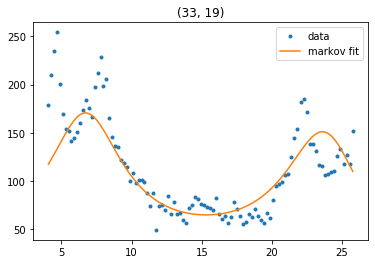

(34, 20)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.033086  7.308690  0.694030    4.285873e-01  4.460486e+05   
StdErrs   0.005680  0.078707  0.061811    1.701135e+07  2.380777e+11   
Initials  0.031145  7.308724  0.694005    4.285873e-01  4.460486e+05   

          delta_amplitude             A         mu      sigma     shift  \
Values       4.348237e+02  1.230406e+02  10.146838  16.590175  0.126119   
StdErrs      2.320864e+08  1.574891e+08   3.957725   6.001735  0.049492   
Initials     4.348237e+02  1.230406e+02  10.146838  16.590176  0.126106   

             offset  
Values    -1.936400  
StdErrs   12.003608  
Initials  -1.936408  


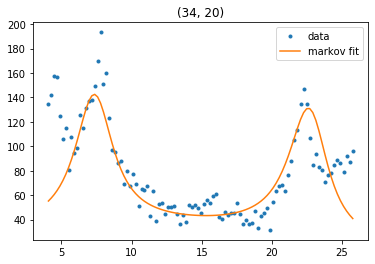

(34, 24)
                Co     Omega     Gamma  delta_position    delta_width  \
Values    0.063272  6.219184  1.663308       -1.980000  483499.804171   
StdErrs        NaN       NaN       NaN             NaN            NaN   
Initials  0.033086  7.308690  0.694030        0.428587  446048.634228   

          delta_amplitude           A         mu      sigma     shift  offset  
Values         122.327276   98.801479  10.248307  16.606766  0.421214 -2.0000  
StdErrs               NaN         NaN        NaN        NaN       NaN     NaN  
Initials       434.823695  123.040553  10.146838  16.590175  0.126119 -1.9364  


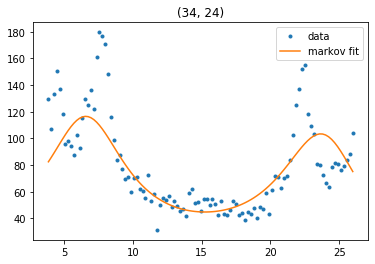

(38, 30)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.063832  7.177347  1.206119        1.485940  1.066387e+06   
StdErrs        NaN       NaN       NaN             NaN           NaN   
Initials  0.020219  7.717703  0.305594        0.966361  6.425509e+05   

          delta_amplitude           A         mu      sigma     shift  \
Values         598.546277  754.349065  10.048991  16.556968  0.387172   
StdErrs               NaN         NaN        NaN        NaN       NaN   
Initials       343.018778  649.824592   9.949496  16.540430  0.028671   

            offset  
Values   -1.986462  
StdErrs        NaN  
Initials  2.000000  


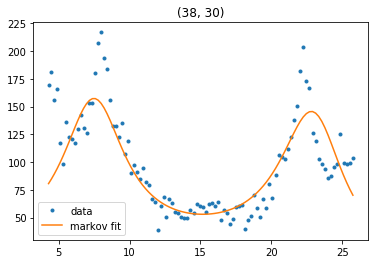

(39, 20)
                Co     Omega     Gamma  delta_position    delta_width  \
Values    0.022876  7.279668  0.560256        1.990090  758820.938593   
StdErrs        NaN       NaN       NaN             NaN            NaN   
Initials  0.020559  7.575003  0.401282       -1.981209  708901.121511   

          delta_amplitude            A         mu      sigma     shift  offset  
Values         893.313176  1094.448323   9.950700  16.577826  0.116670     2.0  
StdErrs               NaN          NaN        NaN        NaN       NaN     NaN  
Initials       541.238653   971.343647  10.020088  16.566208  0.232907     2.0  


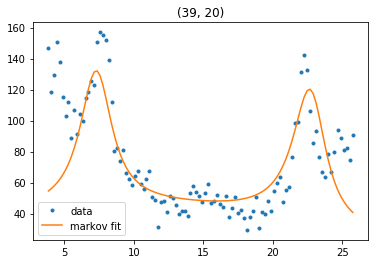

(40, 7)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.012753  7.282488  0.550087    1.990090e+00  7.588209e+05   
StdErrs   0.002002  0.100118  0.094273    1.768945e+07  6.691995e+11   
Initials  0.022876  7.279668  0.560256    1.990090e+00  7.588209e+05   

          delta_amplitude             A        mu      sigma     shift  \
Values       8.932568e+02  1.094448e+03  9.950480  16.577957  0.115411   
StdErrs      7.877576e+08  1.506425e+09  2.877057   5.015488  0.077058   
Initials     8.933132e+02  1.094448e+03  9.950700  16.577826  0.116670   

             offset  
Values     1.994101  
StdErrs   13.638249  
Initials   2.000000  


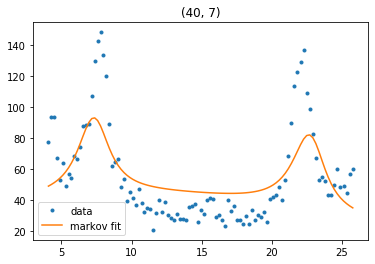

(41, 7)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.019623  7.368543  0.562925    1.990683e+00  8.003654e+05   
StdErrs   0.002473  0.073781  0.067415    1.955037e+07  4.858226e+11   
Initials  0.012753  7.282488  0.550087    1.990090e+00  7.588209e+05   

          delta_amplitude             A        mu      sigma     shift  \
Values       8.932568e+02  8.760904e+02  9.930333  16.586011  0.085693   
StdErrs      5.422078e+08  1.316538e+09  2.796078   4.351670  0.056078   
Initials     8.932568e+02  1.094448e+03  9.950480  16.577957  0.115411   

            offset  
Values    0.609543  
StdErrs   8.626723  
Initials  1.994101  


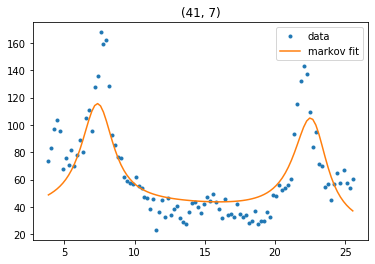

(42, 9)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.029908  7.259353  0.743738    1.886309e+00  8.208435e+05   
StdErrs   0.004429  0.092002  0.075661    1.409028e+07  5.273907e+11   
Initials  0.019623  7.368543  0.562925    1.990683e+00  8.003654e+05   

          delta_amplitude             A         mu      sigma     shift  \
Values       7.990056e+02  7.008727e+02  10.029637  16.602597  0.031572   
StdErrs      5.133599e+08  9.681936e+08   3.816113   5.567595  0.057695   
Initials     8.932568e+02  8.760904e+02   9.930333  16.586011  0.085693   

             offset  
Values    -2.000000  
StdErrs   10.634799  
Initials   0.609543  


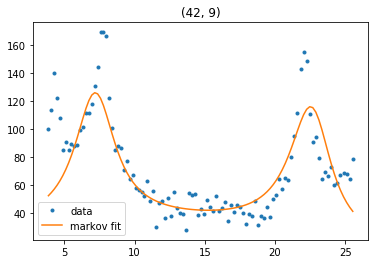

(42, 20)
                Co     Omega     Gamma  delta_position    delta_width  \
Values    0.026938  7.058442  0.671952        0.391094  787488.083505   
StdErrs        NaN       NaN       NaN             NaN            NaN   
Initials  0.029908  7.259353  0.743738        1.886309  820843.480915   

          delta_amplitude           A         mu      sigma     shift  offset  
Values         799.005180  644.547619  10.129745  16.604740  0.199713    -2.0  
StdErrs               NaN         NaN        NaN        NaN       NaN     NaN  
Initials       799.005592  700.872728  10.029637  16.602597  0.031572    -2.0  


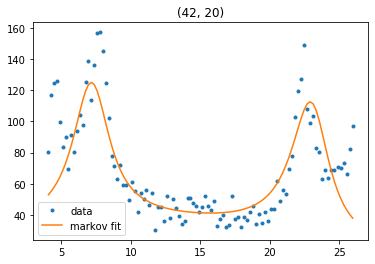

(42, 24)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.030173  7.058453  0.671973    3.910943e-01  7.874881e+05   
StdErrs   0.004612  0.079916  0.064239    4.349463e+06  4.615296e+11   
Initials  0.026938  7.058442  0.671952    3.910943e-01  7.874881e+05   

          delta_amplitude             A         mu      sigma     shift  \
Values       7.990052e+02  6.445476e+02  10.129745  16.604739  0.199704   
StdErrs      4.682796e+08  9.214433e+08   3.685343   5.858742  0.050434   
Initials     7.990052e+02  6.445476e+02  10.129745  16.604740  0.199713   

             offset  
Values    -1.999988  
StdErrs   10.698377  
Initials  -2.000000  


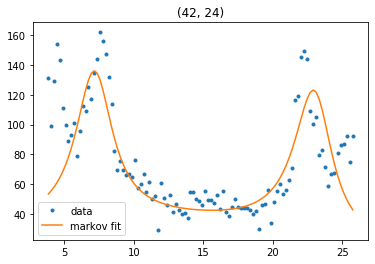

(50, 45)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.024431  7.629556  0.479668       -2.000000    134.189469   
StdErrs   0.038789  0.094139  0.044530     2872.880739  24980.851289   
Initials  0.020174  7.688293  0.374659       -2.000000    107.642742   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.095724  9.005130e+02   9.883187  16.672803  0.223151   
StdErrs         16.812324  8.610865e+08  24.084277  42.033690  0.040786   
Initials         0.060895  1.121048e+03   9.785334  16.656146  0.142925   

              offset  
Values      2.000000  
StdErrs   117.840106  
Initials    2.000000  


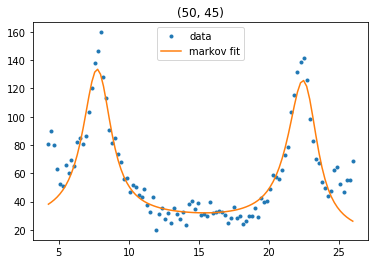

(50, 48)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.033531  7.461768  0.628069       -2.000000     61.547747   
StdErrs   0.046652  0.124715  0.068669      402.186336  11868.020948   
Initials  0.024431  7.629556  0.479668       -2.000000    134.189469   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.067510  1.054469e+03   9.982019  16.689475  0.149120   
StdErrs         10.672623  9.000772e+08  20.532128  36.190952  0.048397   
Initials         0.095724  9.005130e+02   9.883187  16.672803  0.223151   

              offset  
Values      2.000000  
StdErrs   355.867423  
Initials    2.000000  


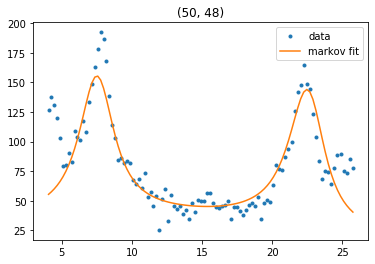

(51, 48)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.027429  7.636894  0.477060       -2.000000    103.270641   
StdErrs   0.042213  0.089478  0.042092     1673.261703  13174.769578   
Initials  0.033531  7.461768  0.628069       -2.000000     61.547747   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.095518  8.452972e+02  10.081839  16.706165  0.155419   
StdErrs         11.041524  9.840677e+08  22.815010  40.941315  0.038121   
Initials         0.067510  1.054469e+03   9.982019  16.689475  0.149120   

              offset  
Values      2.000000  
StdErrs   136.470022  
Initials    2.000000  


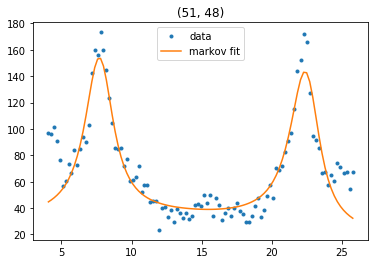

(51, 46)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.108540  6.109515  1.907322        1.079514    50.755443   
StdErrs        NaN       NaN       NaN             NaN          NaN   
Initials  0.027429  7.636894  0.477060       -2.000000   103.270641   

          delta_amplitude           A         mu      sigma     shift  offset  
Values       5.138486e-36  900.008170  10.182658  16.722871  0.611850    -2.0  
StdErrs               NaN         NaN        NaN        NaN       NaN     NaN  
Initials     9.551752e-02  845.297195  10.081839  16.706165  0.155419     2.0  


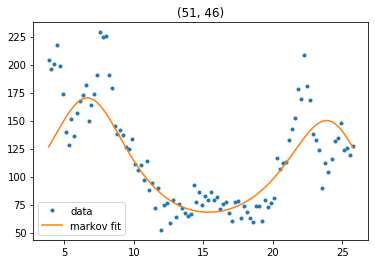

(51, 45)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.022600  7.719784  0.434117   -2.000000e+00  2.432441e+04   
StdErrs   0.014463  0.049564  0.037127    2.924664e+06  1.801581e+10   
Initials  0.024431  7.629556  0.479668   -2.000000e+00  1.341895e+02   

          delta_amplitude             A        mu      sigma     shift  \
Values       1.599163e+01  7.204105e+02  9.982019  16.689475  0.200724   
StdErrs      1.184422e+07  1.196959e+09  9.725431  17.234341  0.035668   
Initials     9.572382e-02  9.005130e+02  9.883187  16.672803  0.223151   

             offset  
Values     2.000000  
StdErrs   69.974397  
Initials   2.000000  


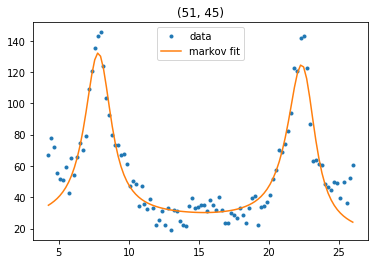

(55, 79)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.022968  7.203598  0.440956   -2.000000e+00  2.574883e+04   
StdErrs   0.010357  0.048274  0.044872    3.891837e+06  2.160756e+10   
Initials  0.023034  7.240055  0.366474   -2.000000e+00  3.401348e+04   

          delta_amplitude             A        mu      sigma     shift  \
Values       3.411084e+01  1.002345e+03  9.492801  16.773090  0.158536   
StdErrs      2.862476e+07  1.297700e+09  7.558702  12.600858  0.040639   
Initials     4.724289e+01  1.249793e+03  9.588688  16.756333  0.192480   

              offset  
Values      2.000000  
StdErrs   108.048992  
Initials    2.000000  


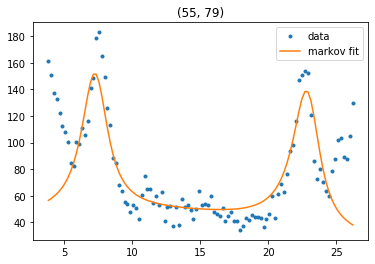

(73, 20)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.030568  7.583639  0.520757       -1.918714  1.225441e+06   
StdErrs        NaN       NaN       NaN             NaN           NaN   
Initials  0.018896  7.654016  0.243581       -1.918714  1.308261e+06   

          delta_amplitude            A         mu      sigma     shift  \
Values        1864.892372  2387.381506  10.102336  16.520379  0.137838   
StdErrs               NaN          NaN        NaN        NaN       NaN   
Initials       575.171048  2387.387121  10.085402  16.520782  0.224502   

            offset  
Values    1.900473  
StdErrs        NaN  
Initials  1.892346  


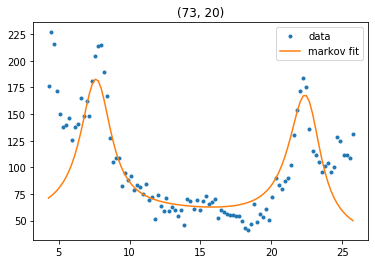

In [17]:
Plot_Elements_Spectrum(matrix, markov_gamma_too_high, fit = 'markov')

(1, 39)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.011518  7.352200  0.128810    2.000000e+00  7.311859e+03   
StdErrs   0.031977  0.021049  0.013873    5.598172e+06  5.860214e+09   
Initials  0.010773  7.343329  0.113388    2.000000e+00  2.911990e+01   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.238725  1.628254e+03   9.668969  16.540509  0.204483   
StdErrs     191330.656943  3.658732e+09  45.438349  75.503650  0.020812   
Initials         0.003070  1.474437e+03   9.573237  16.523985  0.196295   

             offset  
Values     2.000000  
StdErrs   20.633288  
Initials   2.000000  


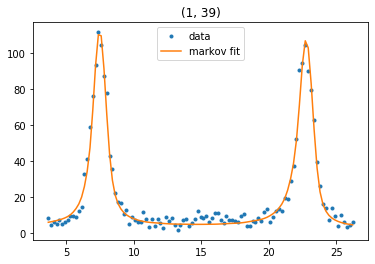

(1, 38)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011073  7.356597  0.110898         2.00000    41.337605   
StdErrs   0.055112  0.027447  0.013687      1679.73697  8573.421844   
Initials  0.010773  7.343329  0.113388         2.00000    29.119897   

          delta_amplitude             A         mu       sigma     shift  \
Values           0.006094  1.769176e+03   9.668969   16.540509  0.218080   
StdErrs          0.958808  3.295163e+09  81.569127  135.024442  0.020077   
Initials         0.003070  1.474437e+03   9.573237   16.523985  0.196295   

             offset  
Values     0.746915  
StdErrs   58.605191  
Initials   2.000000  


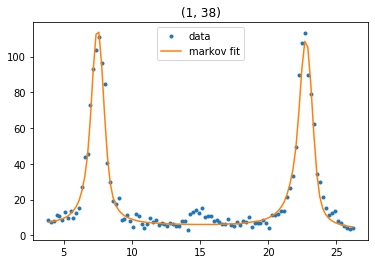

(1, 37)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011687  7.351521  0.123364       -2.000000    10.840962   
StdErrs   0.053771  0.022285  0.013951       12.487825    64.258015   
Initials  0.011233  7.331293  0.116873       -2.000000    12.891867   

          delta_amplitude             A         mu       sigma     shift  \
Values           0.001479  1.336198e+03   9.668193   16.507478  0.192421   
StdErrs          0.015107  2.233404e+09  75.532572  123.860487  0.021701   
Initials         0.002841  1.670248e+03   9.572468   16.490987  0.199361   

            offset  
Values    2.000000  
StdErrs   9.492728  
Initials  2.000000  


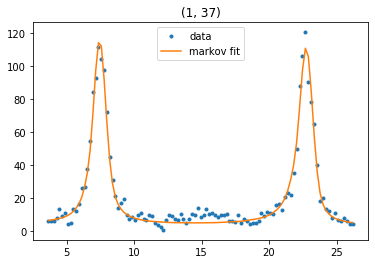

(1, 36)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011601  7.359793  0.113481       -2.000000     6.843192   
StdErrs   0.052389  0.027014  0.015701        2.852697    13.632469   
Initials  0.011233  7.331293  0.116873       -2.000000    12.891867   

          delta_amplitude             A         mu       sigma     shift  \
Values           0.002638  1.336199e+03   9.555155   16.474496  0.224695   
StdErrs          0.006657  2.644832e+09  74.866521  120.498707  0.019437   
Initials         0.002841  1.670248e+03   9.572468   16.490987  0.199361   

             offset  
Values     2.000000  
StdErrs   11.072344  
Initials   2.000000  


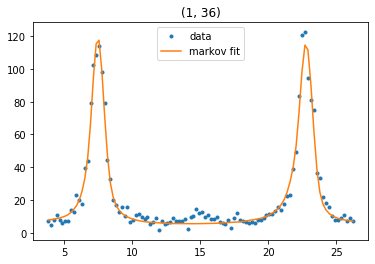

(1, 35)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011270  7.352401  0.115686        2.000000    30.131154   
StdErrs   0.024484  0.021205  0.017056       64.520375   832.117513   
Initials  0.010931  7.354003  0.114434        2.000000    27.253962   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.009943  1.961858e+03   9.572468  16.490987  0.225449   
StdErrs          0.168066  2.943314e+09  35.527136  57.972503  0.020095   
Initials         0.004613  2.087798e+03   9.669160  16.507494  0.223695   

             offset  
Values    -1.902321  
StdErrs   30.328000  
Initials   2.000000  


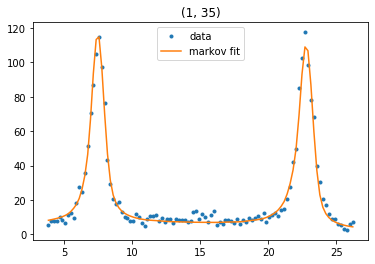

(1, 34)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011243  7.365357  0.098086        2.000000    32.042467   
StdErrs   0.031203  0.025483  0.015657      193.480524  1929.354728   
Initials  0.011393  7.369106  0.117358        2.000000    30.658162   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.006638  2.567278e+03   9.864496  16.540542  0.016562   
StdErrs          0.226534  5.490410e+09  45.122362  74.708581  0.020153   
Initials         0.004886  2.290159e+03   9.766828  16.524018  0.207586   

             offset  
Values     1.468157  
StdErrs   24.673786  
Initials   1.736115  


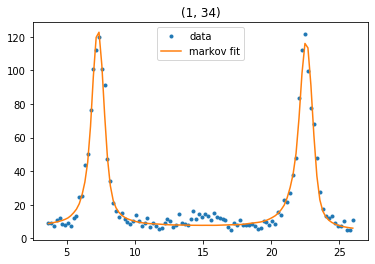

(1, 33)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011398  7.339642  0.125028        2.000000    30.353345   
StdErrs   0.025399  0.021600  0.018131       67.556089   906.394247   
Initials  0.011642  7.347738  0.109530        2.000000    28.058634   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.010502  3.309717e+03   9.670127  16.507476  0.225771   
StdErrs          0.189012  5.618442e+09  35.824462  59.685716  0.020987   
Initials         0.005550  3.349201e+03   9.767805  16.524000  0.232596   

             offset  
Values    -1.020004  
StdErrs   34.715244  
Initials   2.000000  


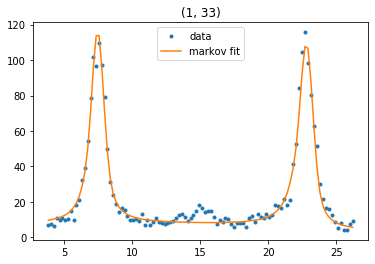

(1, 32)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.011731  7.367866  0.118708         2.00000    30.908773   
StdErrs   0.027945  0.021161  0.017405        82.79509  1429.245633   
Initials  0.011250  7.371081  0.105688         2.00000    28.795009   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.006990  2.919572e+03   9.965134  16.557081  0.212846   
StdErrs          0.164382  5.591713e+09  36.363658  64.392495  0.022874   
Initials         0.005722  2.803427e+03   9.866469  16.540540  0.213795   

             offset  
Values     0.985934  
StdErrs   33.122933  
Initials   2.000000  


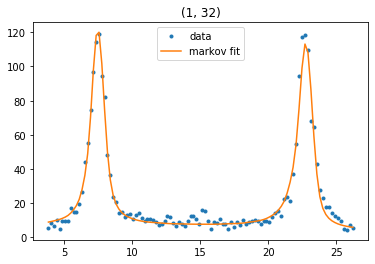

(1, 31)
                Co     Omega     Gamma  delta_position  delta_width  \
Values    0.010916  7.358446  0.102209        2.000000    27.570481   
StdErrs   0.033255  0.025509  0.018241      192.712105   694.570550   
Initials  0.011250  7.371081  0.105688        2.000000    28.795009   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.005272  2.297181e+03   9.965134  16.557081  0.222136   
StdErrs          0.065117  5.139627e+09  47.396447  83.810334  0.019590   
Initials         0.005722  2.803427e+03   9.866469  16.540540  0.213795   

             offset  
Values     2.000000  
StdErrs   53.491361  
Initials   2.000000  


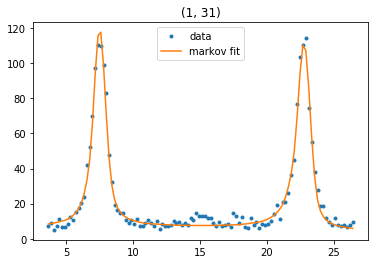

(1, 30)
                Co     Omega     Gamma  delta_position   delta_width  \
Values    0.011582  7.363408  0.117260       -1.999975     53.385188   
StdErrs   0.024749  0.020979  0.018268      737.471714  34162.731749   
Initials  0.011434  7.357397  0.111036       -2.000000     23.972811   

          delta_amplitude             A         mu      sigma     shift  \
Values           0.011153  2.117614e+03  10.066799  16.540560  0.256941   
StdErrs          5.653660  3.347647e+09  32.041126  58.580394  0.019637   
Initials         0.005477  2.610999e+03   9.967127  16.524036  0.250403   

              offset  
Values      0.506203  
StdErrs   259.636088  
Initials    2.000000  


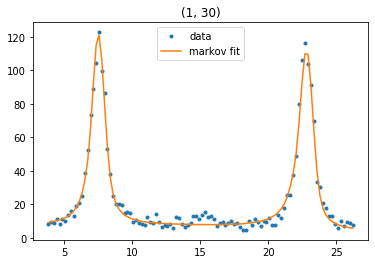

In [21]:
Plot_Elements_Spectrum(matrix, boni[130:140], fit = 'markov')

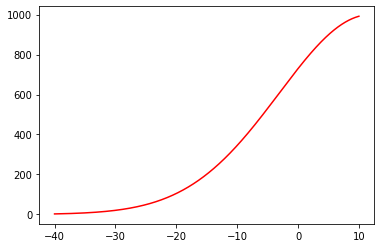

,mu,sigma
Values,11.936962,15.036250
StdErrs,19.757353,4.940734
Initials,10.851784,16.706945


In [8]:
plt.figure()
x = np.linspace(-40, 10, 5000)
for (ii,jj) in boni[-1:]:
    plt.plot(x, gaussian(x, 1000, *matrix[ii][jj].Markov_Fit_Params[list(cols_gauss)].values[0][1:]), c = 'r')
    plt.show()
matrix[ii][jj].Markov_Fit_Params[['mu', 'sigma']]


In [9]:
################ TOTALE

with open(now_path+'y_tot_fit.txt', 'r') as fin:
    y_fits = fin.readlines()

with open(now_path+'cost_tot.txt', 'r') as fin:
    costi = fin.readlines()
with open(now_path+'tot_fit_params.txt', 'r') as fin:
    lines   =   fin.readlines()

if (len(boni) != len(lines)):
    raise ValueError("Incompatibilità tra lunghezza file parametri ({}) e informazioni fit ({})".format(len(boni), len(lines)))

for (line, y_fit, cost, (ii,jj)) in zip(lines, y_fits, costi,  boni) :
#for (line, cost, (ii,jj)) in zip(lines, costi,  boni) :
    matrix[ii][jj].Recover_Tot_Fit_Params(line)
    matrix[ii][jj].Recover_y_fit(np.array(y_fit[1:-2].split(), dtype = float))
    matrix[ii][jj].Recover_cost_tot(float(cost))

print('Ok ho recuperato le informazioni del Fit Totale')

Ok ho recuperato le informazioni del Fit Totale


In [10]:
#HISTOGRAMs
tot_Omegas = np.array([matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] for (ii,jj) in boni])
tot_Gammas =  np.array([matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] for (ii,jj) in boni])
taus       = np.array([matrix[ii][jj].Tot_Fit_Params['tau'].values[0] for (ii,jj) in boni])

plt.figure()
plt.title('Omega distribution over sample - tot')
_ = plt.hist(tot_Omegas, bins = 50, label = 'omega',histtype = 'bar', stacked = True, rwidth= 0.8,  color = 'maroon')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Omegas), np.std(tot_Omegas)))
plt.savefig(now_path+'Omega_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Gamma distribution over sample - tot ')
_ = plt.hist(tot_Gammas, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8)
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(tot_Gammas), np.std(tot_Gammas)))
plt.savefig(now_path+'Gamma_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()
plt.figure()
plt.title('Tau distribution over sample - tot')
_ = plt.hist(taus, bins = 50, label = 'gamma', histtype = 'bar', stacked = True, rwidth= 0.8, color = 'darkgoldenrod')
plt.legend(title='Mean = {:3.2f}\nStd = {:3.2f}'.format(np.mean(taus), np.std(taus)))
plt.savefig(now_path+'tau_tot_distribution.pdf', format = 'pdf', bbox_inches='tight')
plt.show()
plt.close()


KeyError: 'tau'

In [11]:
#Parametri di Interesse per analisi
tot_too_bad = ()
tot_too_good  = ()
tot_omega_too_high =  ()
tot_gamma_too_bad = ()
tau_not_bad = []

tot_omega_max = np.mean(tot_Omegas)+5*np.std(tot_Omegas)
tot_gamma_max = np.mean(tot_Gammas)+5*np.std(tot_Gammas)
cost_max = 1000
cost_min = 50


tot_too_bad = Get_Bad_Elements(matrix, boni, cost_max, fit = 'tot')
tot_too_good = Get_Good_Elements(matrix, boni, cost_min, fit = 'tot')
tot_omega_too_high = Whose_Param_Too_High('Omega', tot_omega_max, 'markov', matrix, boni)
tot_gamma_too_high = Whose_Param_Too_High('Gamma', tot_gamma_max, 'markov', matrix, boni)


#aggiunte 
omega_different_from_mark = []
gamma_different_from_mark = []

percentage_diff = 0.8
tot_too_offset = ()
percentage_gamma = 100
max_offset = 30
almost_height = ()

for (ii,jj) in boni:
    
    perc_omega = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100
    perc_gamma = matrix[ii][jj].Tot_Fit_Params['Omega'].values[0]*percentage_diff/100

    if (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] > matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Omega'].values[0] < matrix[ii][jj].Markov_Fit_Params['Omega'].values[0] - perc_gamma):
        omega_different_from_mark.append((ii,jj))
    if (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] > matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] + perc_gamma) | (matrix[ii][jj].Tot_Fit_Params['Gamma'].values[0] < matrix[ii][jj].Markov_Fit_Params['Gamma'].values[0] - perc_omega):
        gamma_different_from_mark.append((ii,jj))
    if matrix[ii][jj].Tot_Fit_Params.T.StdErrs['Gamma'] > (matrix[ii][jj].Tot_Fit_Params.T.Values['Gamma']*(percentage_gamma/100)):
        tot_gamma_too_bad += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['offset'].values[0] > max_offset:
        tot_too_offset += ((ii,jj),)
    if matrix[ii][jj].y.max() > 15000:
        tot_almost_height += ((ii,jj),)
    if matrix[ii][jj].Tot_Fit_Params['tau']['StdErrs'] < matrix[ii][jj].Tot_Fit_Params['tau']['Values']:
        tau_not_bad.append((ii,jj))


print('\n\n\n\nHo trovato per i dati fit markov in {} :\n'.format(now_path))

print('{} elementi con chi quadro > {} '.format(len(tot_too_bad), cost_max))
print('{} elementi con chi quadro < {} \n'.format(len(tot_too_good), cost_min))


print('{} elementi con Omega > Omega max {:3.2f}'.format(len(tot_omega_too_high), tot_omega_max))
print('{} elementi con Gamma > Gamma max {:3.2f}\n'.format(len(tot_gamma_too_high), tot_gamma_max))


print('{} elementi con Gamma con errore percentuale > {} \n'.format(len(markov_gamma_too_bad), percentage_gamma))
print('{} elementi con offset > {} \n'.format(len(tot_too_offset), max_offset))

print('{} elementi il cui fit tot di Omega è diverso del {} percento da markoviano'.format(len(omega_different_from_mark), percentage_diff))
print('{} elementi il cui fit tot di Gamma è diverso del {} percento da markoviano'.format(len(gamma_different_from_mark), percentage_diff))
print('{} elementi il cui fit di tau non è cosi male..'.format(len(tau_not_bad)), tau_not_bad)


I found 20 bad elements out of 7496

I found 54 good elements out of 7496

(39, 11) ha Gamma= 12.59
(75, 40) ha Gamma= 13.43
(82, 57) ha Gamma= 88.76


KeyError: 'tau'

In [12]:
Plot_Elements_Spectrum(matrix, tau_not_bad[:10], fit = 'tot')

Completata Parameter_Map per Omega
Ho trovato 69 elementi saturati


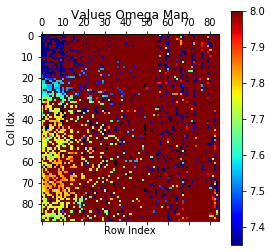

Completata Parameter_Map per Omega
Ho trovato 69 elementi saturati


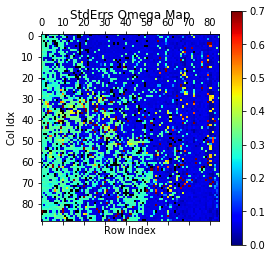

Completata Parameter_Map per Gamma
Ho trovato 69 elementi saturati


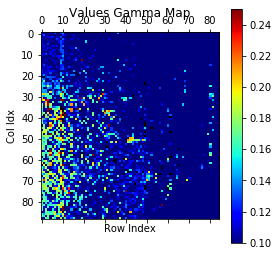

Completata Parameter_Map per Gamma
Ho trovato 69 elementi saturati


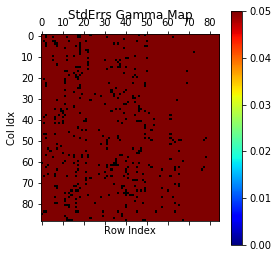

KeyError: 'tau'

In [13]:
omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 7.35, 8., fig = 'omega_tot_map', path=now_path)
Delta_omega_tot_map, _ = Get_Parameter_Map('tot', 'Omega', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_omega_tot_map', path=now_path, Deltas = True)
gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0.1,0.25, fig = 'Gamma_tot_map', path=now_path)
Delta_gamma_tot_map, _ = Get_Parameter_Map('tot', 'Gamma', matrix, n_rows, n_cols, excluded, 'jet', 0,0.05, fig = 'Delta_gamma_tot_map', path=now_path, Deltas = True)
tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0., 200, fig = 'tau_map', path=now_path)
Delta_tau_map, _ = Get_Parameter_Map('tot', 'tau', matrix, n_rows, n_cols, excluded, 'jet', 0,0.7, fig = 'Delta_tau_map', path=now_path, Deltas = True)

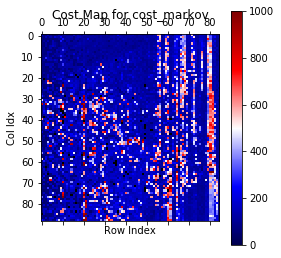

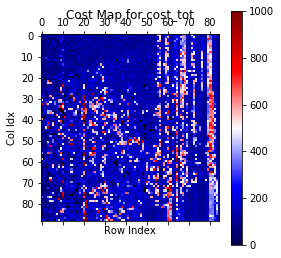

In [14]:
markov_cost_map = Get_cost_map(matrix, 'markov', len(rows), len(cols), 'markov_cost_map', path = now_path)
tot_cost_map = Get_cost_map(matrix, 'tot', len(rows), len(cols), 'tot_cost_map', path = now_path)
